# AWOT matching

This is code to do something interesting.

In [1]:
%config InlineBackend.figure_formats = {'png', 'retina'}
%pylab inline
import pyart
import awot
import os, glob
import awot
import pandas as pd
from awot.graph import create_basemap, FlightLevel, RadarHorizontalPlot
from netCDF4 import date2num, num2date
import datetime
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc)
import copy
from numba import jit

def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='ZC'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    masked_field = np.ma.asanyarray(field)
    fill_value = -32768
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', radar.fields[dz_field]['data'].mask)
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

@jit
def rolling_window(a, window):
    """ create a rolling window object for application of functions
    eg: result=np.ma.std(array, 11), 1)"""
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1], )
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

@jit
def texture(myradar, var):
    """Determine a texture field using an 11pt stdev
    texarray=texture(pyradarobj, field)
    """
    fld = myradar.fields[var]['data']
#    print(fld.shape)
    tex = np.ma.zeros(fld.shape)
    for timestep in range(tex.shape[0]):
        ray = np.ma.std(rolling_window(fld[timestep, :], 5), 1)
        tex[timestep, 2:-2] = ray
        tex[timestep, 0:2] = np.ones(1) * ray[0]
        tex[timestep, -2:] = np.ones(2) * ray[-1]
    return tex

@jit
def do_auto_qc(iradar):
    dzN = extract_unmasked_data(iradar, 'ZZ')
    dpN = extract_unmasked_data(iradar, 'PH')
    # Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
    rng2d, az2d = np.meshgrid(iradar.range['data'], iradar.azimuth['data'])
    kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=20., gs=125.0, window=1.5,nfilter=1)
    iradar = add_field_to_radar_object(kdN, iradar, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase', 
                                   dz_field='ZZ')
    iradar = add_field_to_radar_object(fdN, iradar, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase', 
                                   dz_field='ZZ')

    iradar = add_field_to_radar_object(sdN, iradar, field_name='SDP', units='deg**2/km**2', 
                                   long_name='Sigma Differential Phase',
                                   standard_name='Sigma Differential Phase', 
                                   dz_field='ZZ')

    bad=-32768
    iradar.fields['KDP']['data']=np.ma.masked_equal(iradar.fields['KDP']['data'],bad)
    iradar.fields['SDP']['data']=np.ma.masked_equal(iradar.fields['SDP']['data'],bad)
    iradar.fields['FDP']['data']=np.ma.masked_equal(iradar.fields['FDP']['data'],bad)
    
    cor_z = copy.deepcopy(iradar.fields['ZZ'])
    cor_z['data'] = np.ma.masked_where(radar.fields['RH']['data'] < 0.75, cor_z['data'])
    cor_z['data'] = np.ma.masked_where(radar.fields['SDP']['data'] > 12, cor_z['data'])
    cor_z['data'] = np.ma.masked_where(radar.fields['DR']['data'] < -2., cor_z['data'])
    cor_z['data'] = np.ma.masked_where(radar.fields['DR']['data'] > 3., cor_z['data'])
#    cor_z['data'] = np.ma.masked_where(radar.fields['normalized_coherent_power']['data'] < .3, cor_z['data'])

    
    cor_z['least_significant_digit'] = 2
    cor_z['valid_max'] = 80.0
    cor_z['valid_min'] = -30.0
    cor_z['standard_name'] = 'corrected_reflectivity'
    cor_z['long_name'] = 'corrected_reflectivity'
    cor_z['least_significant_digit'] = 2
    cor_z['units'] = 'dBZ'

    iradar.add_field('CORDBZ',cor_z)
    
    Ztext = copy.deepcopy(iradar.fields['CORDBZ'])
    Ztext['data'] = texture(iradar,'CORDBZ')
    Ztext['least_significant_digit'] = 2
    Ztext['valid_max'] = 80.0
    Ztext['valid_min'] = -30.0
    Ztext['standard_name'] = 'corrected_reflectivity_texture'
    Ztext['long_name'] = 'corrected_reflectivity_texture'
    Ztext['least_significant_digit'] = 2
    Ztext['units'] = 'dBZ'
    iradar.add_field('Ztext',Ztext)
    
    iradar.fields['CORDBZ']['data'] = np.ma.masked_where(radar.fields['Ztext']['data'] > 7., cor_z['data'])

    fields=['RH','DR','KDP']
    for ifield in fields:
        iradar.fields[ifield]['data']=np.ma.masked_where(np.ma.getmask(iradar.fields['CORDBZ']['data']), iradar.fields[ifield]['data'])
#    pyart.io.cfradial.write_cfradial('test.cfradial.nc',iradar, format='NETCDF4')
    

Populating the interactive namespace from numpy and matplotlib


In [6]:
folders=glob.glob("/data/gpm/a/shared/snesbitt/olympex/cloud_microphysics_Citation/UND_cloud_microphysics/data/20151112_184913")

for flights in folders:
    print(flights.split('/')[-1])
    str1=flights.split('/')[-1]
    str2=str1[2:4]+'_'+str1[4:6]+'_'+str1[6:8]+'_'+str1[9:11]+'_'+str1[11:13]+'_'+str1[13:15]
    str3=str1[0:8]
    flightdt=datetime.datetime.strptime(str1,'%Y%m%d_%H%M%S')
    

    # Set the project name
    Project="OLYMPEx"
    # Set the path for data file
    flname="/data/gpm/a/shared/snesbitt/olympex/cloud_microphysics_Citation/UND_cloud_microphysics/data/" + str1 + '/' + str2 + ".olympex"
    
    fl = awot.io.flight.read_nasa_ames(flname,platform='citation',verbose=False)
    startdate=datetime.datetime.strftime(fl['time']['data'][0],'%Y%m%d')
    enddate=datetime.datetime.strftime(fl['time']['data'][-1],'%Y%m%d')
    
    rfiles = []
    rfiles.append(glob.glob('/data/gpm/a/snesbitt/gpm/olympex/cf/'+startdate+'/*PPI.nc'))
    if startdate != enddate:
        rfiles.append(glob.glob('/data/gpm/a/snesbitt/gpm/olympex/cf/'+enddate+'/*PPI.nc'))
        rfiles=rfiles[0]+rfiles[1]
    else:
        rfiles=rfiles[0]
    
    rfiles = sorted(rfiles)

    rflist = []
    volstart = []
    for i,filer in enumerate(rfiles):
        rstr1=filer.split('/')[-1]
        mindatet=datetime.datetime.strptime(rstr1[6:21],'%Y%m%d_%H%M%S')
        maxdatet=datetime.datetime.strptime(rstr1[29:44],'%Y%m%d_%H%M%S')
        
        if (mindatet > min(fl['time']['data'])) & (maxdatet < max(fl['time']['data'])):
            radar=pyart.io.read_cfradial(filer)
            radar=radar.extract_sweeps(np.arange(0,radar.nsweeps-1))
            do_auto_qc(radar)
            rflist.append(radar)
            volstart.append(min(fl['time']['data']))
            print("File {} is in time bounds".format(filer))
        else:
            print("File {} is OUT of time bounds".format(filer))
    print(len(rflist))
    rflist2=[x for y, x in sorted(zip(volstart, rflist))]
    rflist2
    
    und_set = [fl['time']['data'][0].isoformat(), fl['time']['data'][-1].isoformat()]
    rmatch = awot.util.RadarMatch(fl, rflist2,
                                       mask_above=1E5,
                                       start_time=und_set[0], end_time=und_set[1],
                                       field_match_dict=['CORDBZ','SDP','KDP','DR',
                                                         'SQ','VR','RH'])

    kdWKR = rmatch.kdtree(leafsize=16, query_k=8, Barnes=True, K_d=5e2, Zfield='CORDBZ')
    
    m1=kdWKR.matchinfo['match_indicies'][:,0]
    m2=kdWKR.matchinfo['match_indicies'][:,1]
    m3=kdWKR.matchinfo['match_indicies'][:,2]
    m4=kdWKR.matchinfo['match_indicies'][:,3]
    m5=kdWKR.matchinfo['match_indicies'][:,4]
    m6=kdWKR.matchinfo['match_indicies'][:,5]
    m7=kdWKR.matchinfo['match_indicies'][:,6]
    m8=kdWKR.matchinfo['match_indicies'][:,7]
    
    data=pd.DataFrame({'quality_controlled_reflectivity':kdWKR.data['CORDBZ']['data'],
            'specific_differential_phase':kdWKR.data['KDP']['data'],
            'standard_deviation_differential_phase':kdWKR.data['SDP']['data'],
             'standard_deviation_reflectivity':kdWKR.data['Ztext']['data'],
             'cross_correlation_ratio':kdWKR.data['RH']['data'],
             'differential_reflectivity':kdWKR.data['DR']['data'],
             'normalized_coherent_power':kdWKR.data['SQ']['data'],
             'reflectivity':kdWKR.data['CZ']['data'],
             'total_power':kdWKR.data['ZZ']['data'],
             'm1':m1,
             'm2':m2,
             'm3':m3,
             'm4':m4,
             'm5':m5,
             'm6':m6,
             'm7':m7,
             'm8':m8},index=kdWKR.flight['time']['data'])

    data.to_csv(str1+'_'+Project+'_match.csv')

20151112_184913
File /data/gpm/a/snesbitt/gpm/olympex/cf/20151112/cfrad.20151112_130211.000_to_20151112_130329.000_NPOL1_v1_PPI.nc is OUT of time bounds
File /data/gpm/a/snesbitt/gpm/olympex/cf/20151112/cfrad.20151112_140237.000_to_20151112_140355.000_NPOL1_v1_PPI.nc is OUT of time bounds
File /data/gpm/a/snesbitt/gpm/olympex/cf/20151112/cfrad.20151112_142347.000_to_20151112_142504.000_NPOL1_v1_PPI.nc is OUT of time bounds
File /data/gpm/a/snesbitt/gpm/olympex/cf/20151112/cfrad.20151112_144210.000_to_20151112_144327.000_NPOL1_v1_PPI.nc is OUT of time bounds
File /data/gpm/a/snesbitt/gpm/olympex/cf/20151112/cfrad.20151112_150031.000_to_20151112_150149.000_NPOL1_v1_PPI.nc is OUT of time bounds
File /data/gpm/a/snesbitt/gpm/olympex/cf/20151112/cfrad.20151112_152037.000_to_20151112_152154.000_NPOL1_v1_PPI.nc is OUT of time bounds
File /data/gpm/a/snesbitt/gpm/olympex/cf/20151112/cfrad.20151112_153900.000_to_20151112_154019.000_NPOL1_v1_PPI.nc is OUT of time bounds
File /data/gpm/a/snesbitt

In [11]:
np.shape(kdWKR.indices_nd)

()

In [7]:
enumerate(rfiles)

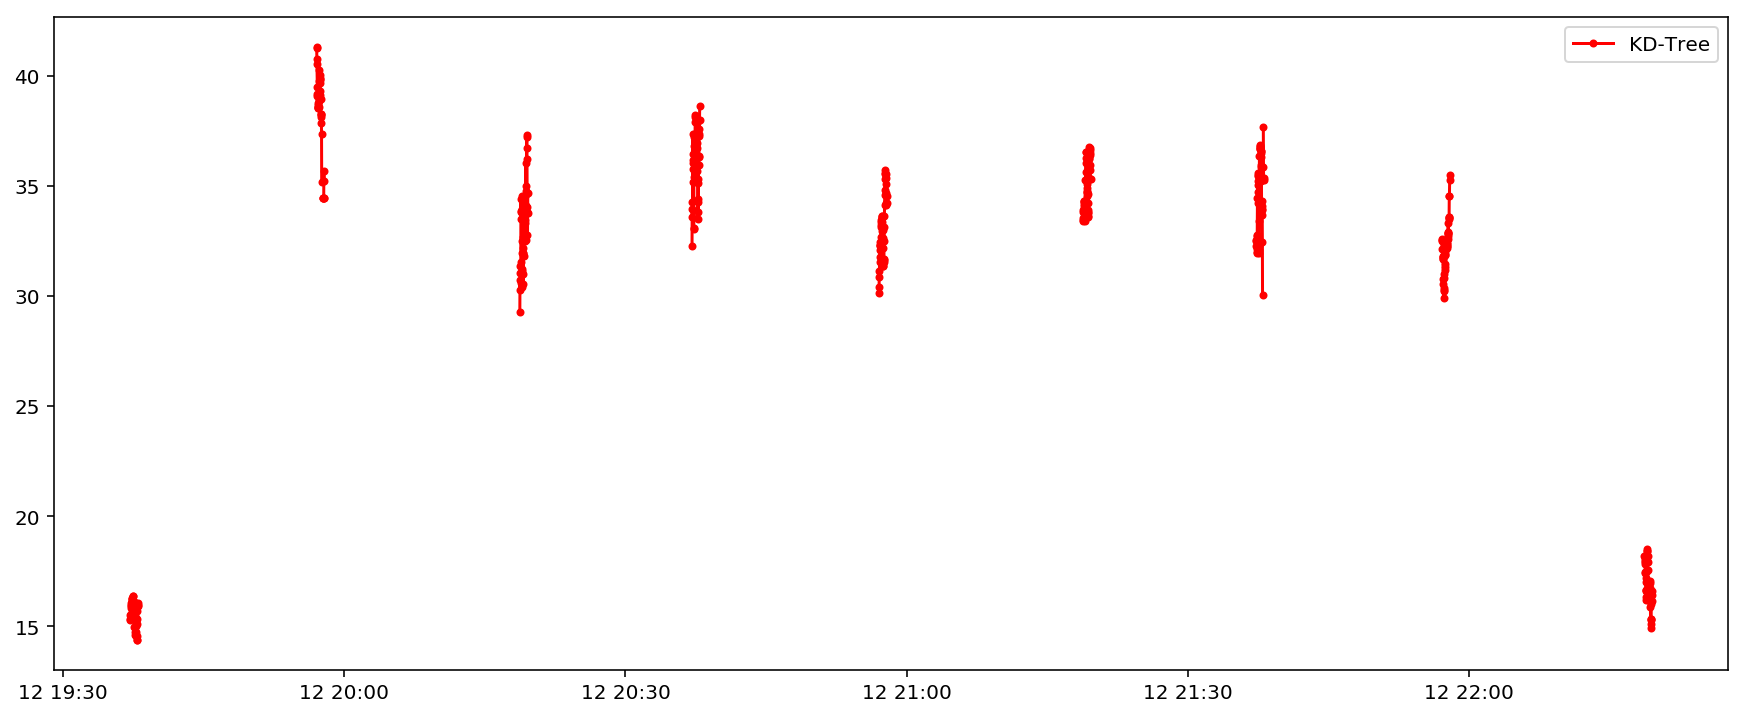

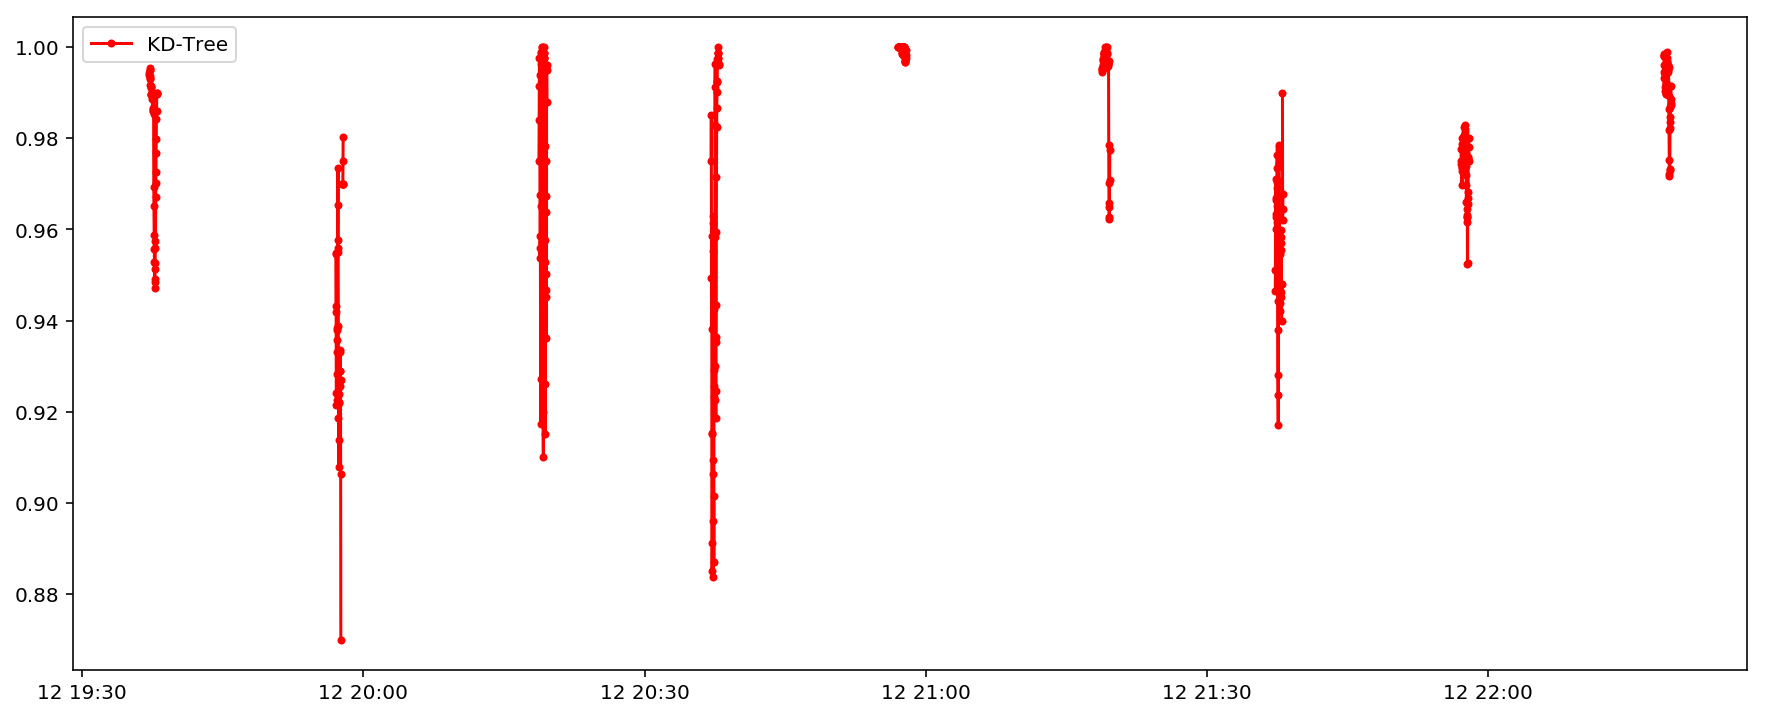

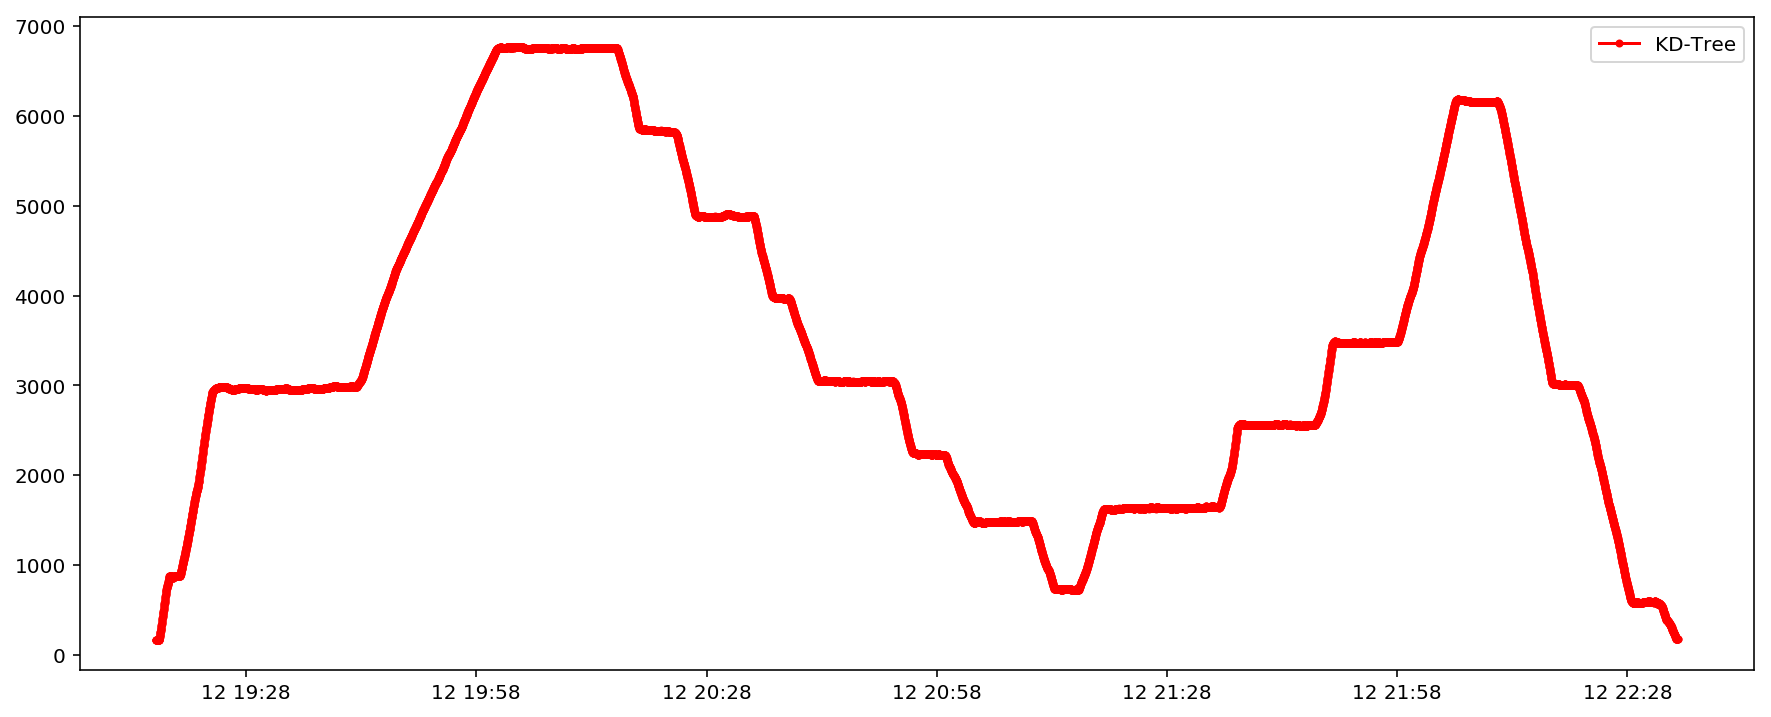

In [8]:
    
fig,ax = plt.subplots(1,1, figsize=(15,6))

#plt.plot(kdKUEX.flight['time']['data'], kdKUEX.flight['turb']['data'], '-ok', ms=3, lw=3, label='UWKA')
plt.plot(kdWKR.flight['time']['data'], kdWKR.data['CORDBZ']['data'], '-or', ms=3, label='KD-Tree')
#plt.plot(nnWKR.flight['time']['data'], nnWKR.data['reflectivity']['data'], '-og', ms=3, label='Nearest neighbour')
#plt.plot(nntWKR.flight['time']['data'], nntWKR.data['reflectivity']['data'], '-ok', ms=3, label='Nearest neighbour tunnel')
#plt.xlim([datetime.datetime(2012,2,18,10,35),datetime.datetime(2012,2,18,10,40)])
plt.legend()

fig,ax = plt.subplots(1,1, figsize=(15,6))

#plt.plot(kdKUEX.flight['time']['data'], kdKUEX.flight['turb']['data'], '-ok', ms=3, lw=3, label='UWKA')
plt.plot(kdWKR.flight['time']['data'], kdWKR.data['RH']['data'], '-or', ms=3, label='KD-Tree')
#plt.plot(nnWKR.flight['time']['data'], nnWKR.data['reflectivity']['data'], '-og', ms=3, label='Nearest neighbour')
#plt.plot(nntWKR.flight['time']['data'], nntWKR.data['reflectivity']['data'], '-ok', ms=3, label='Nearest neighbour tunnel')
#plt.xlim([datetime.datetime(2012,2,18,10,35),datetime.datetime(2012,2,18,10,40)])
plt.legend()

fig,ax = plt.subplots(1,1, figsize=(15,6))

#plt.plot(kdKUEX.flight['time']['data'], kdKUEX.flight['turb']['data'], '-ok', ms=3, lw=3, label='UWKA')
plt.plot(kdWKR.flight['time']['data'], kdWKR.flight['altitude']['data'], '-or', ms=3, label='KD-Tree')
#plt.plot(nnWKR.flight['time']['data'], nnWKR.data['reflectivity']['data'], '-og', ms=3, label='Nearest neighbour')
#plt.plot(nntWKR.flight['time']['data'], nntWKR.data['reflectivity']['data'], '-ok', ms=3, label='Nearest neighbour tunnel')
#plt.xlim([datetime.datetime(2012,2,18,10,35),datetime.datetime(2012,2,18,10,40)])
plt.legend()

In [24]:
{flight:kdWKR.flight,RadarMatch:kdWKR.flight}

NameError: name 'kdWKR' is not defined

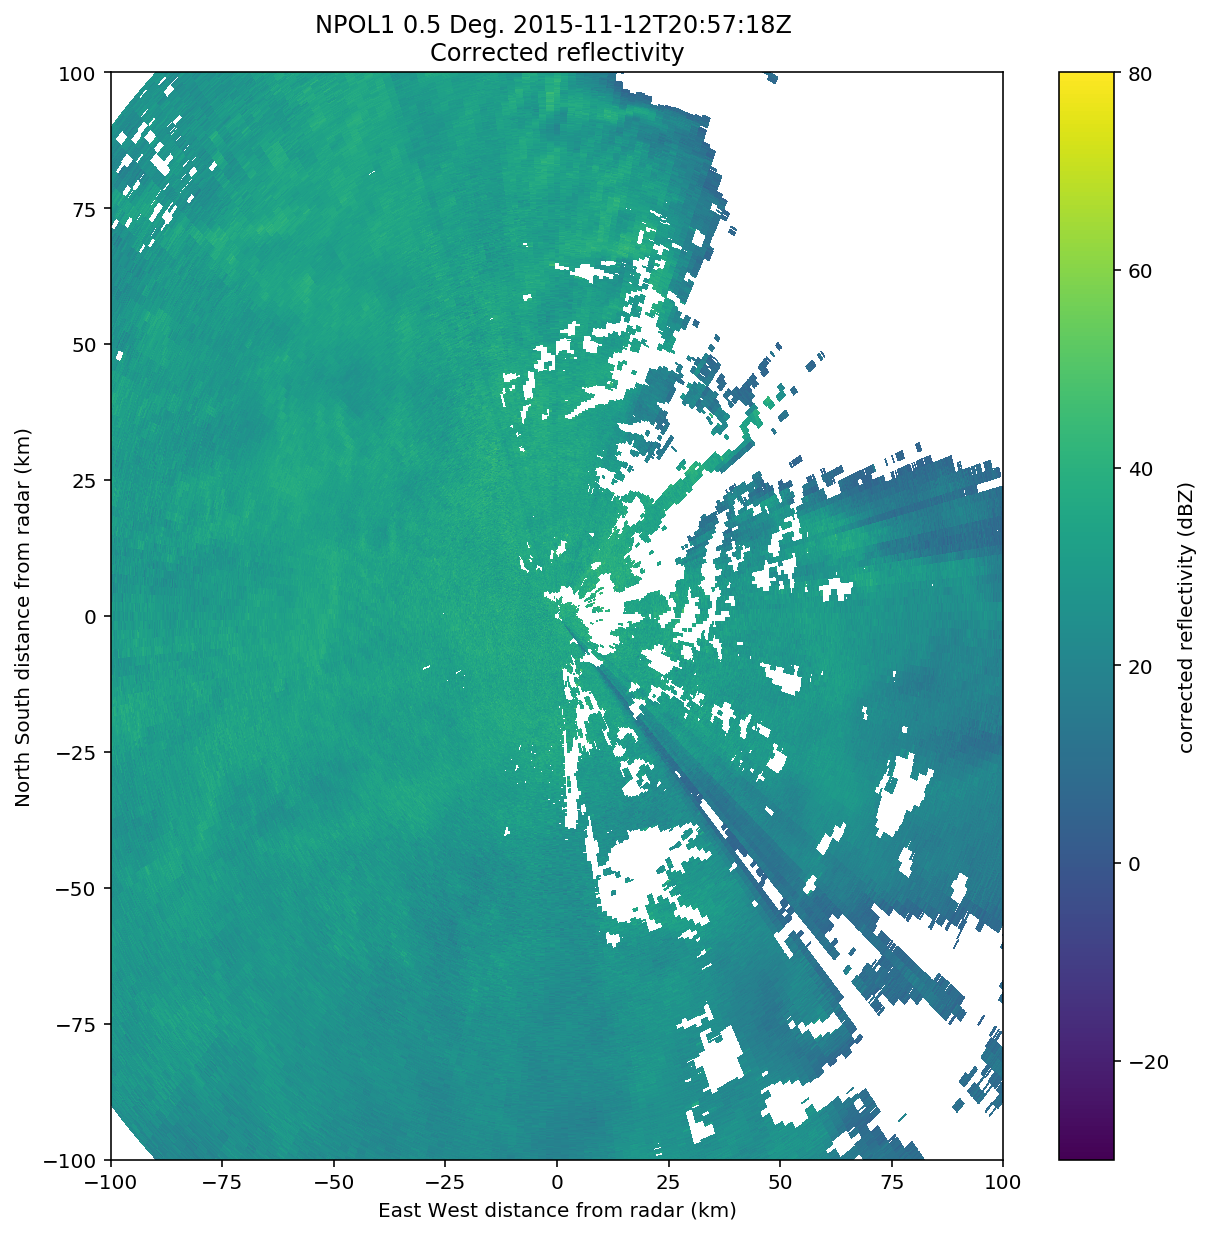

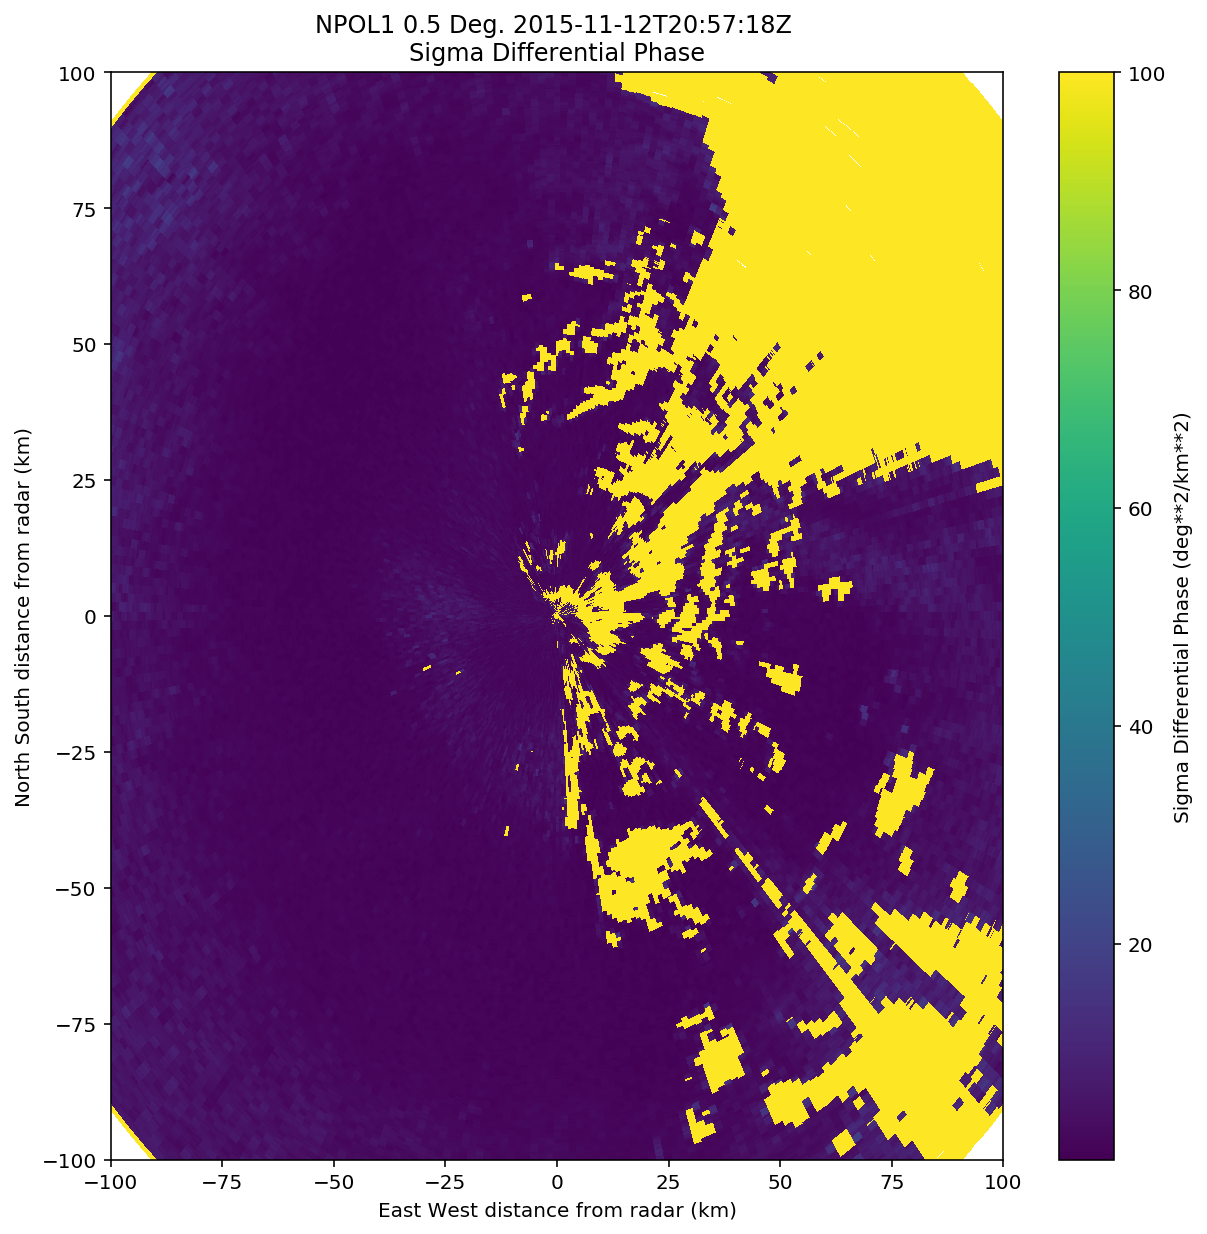

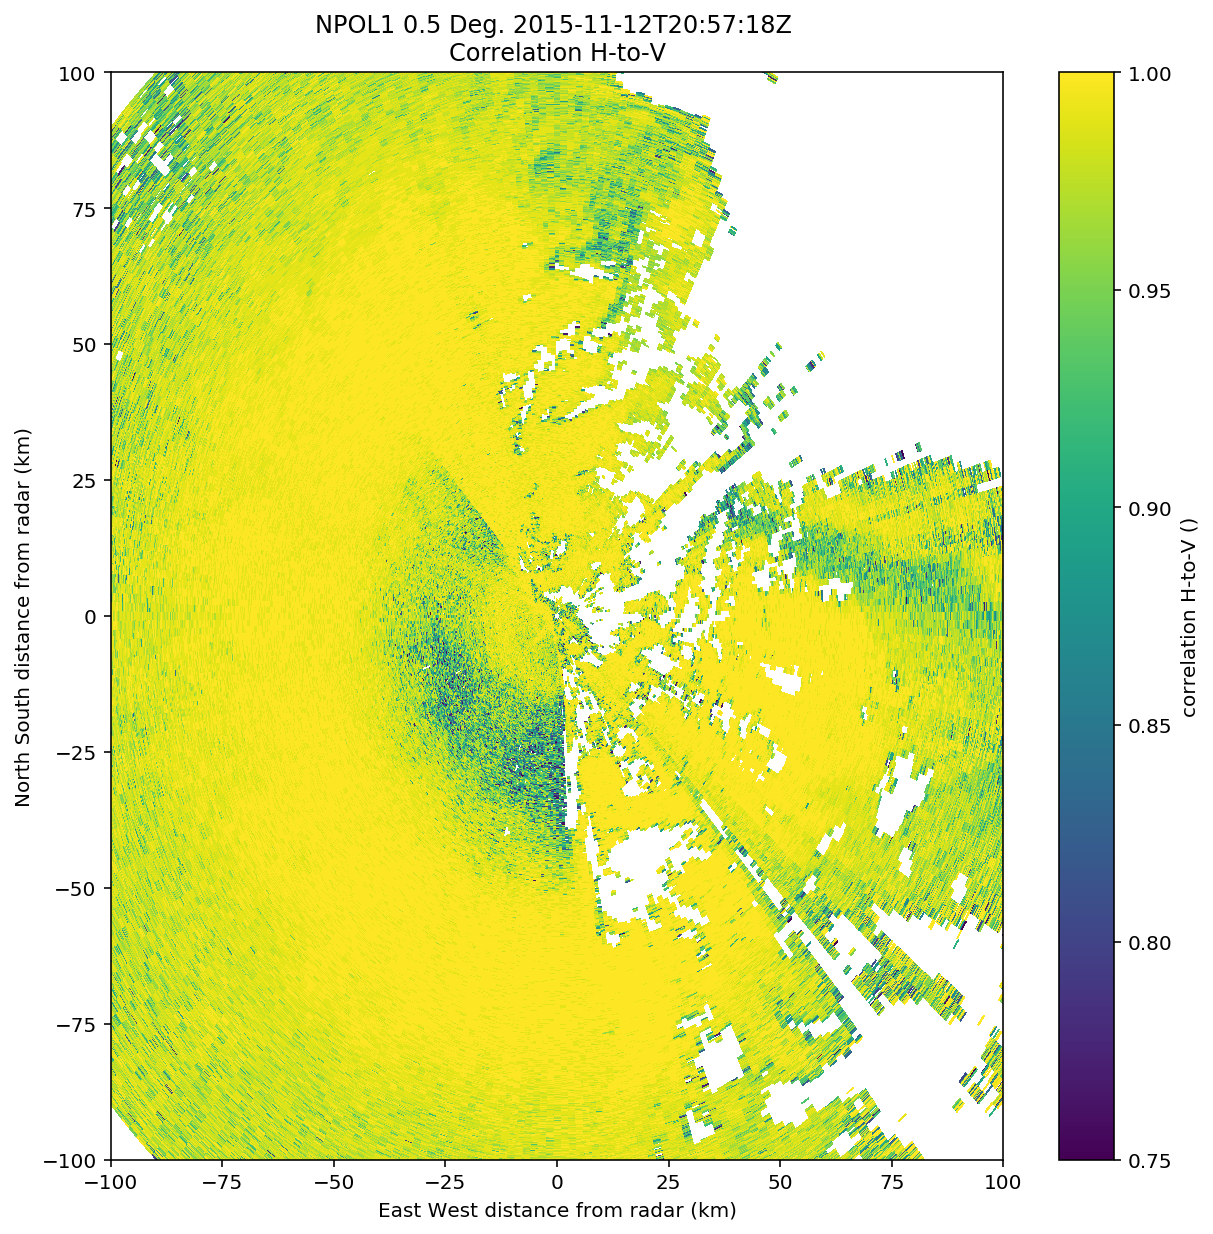

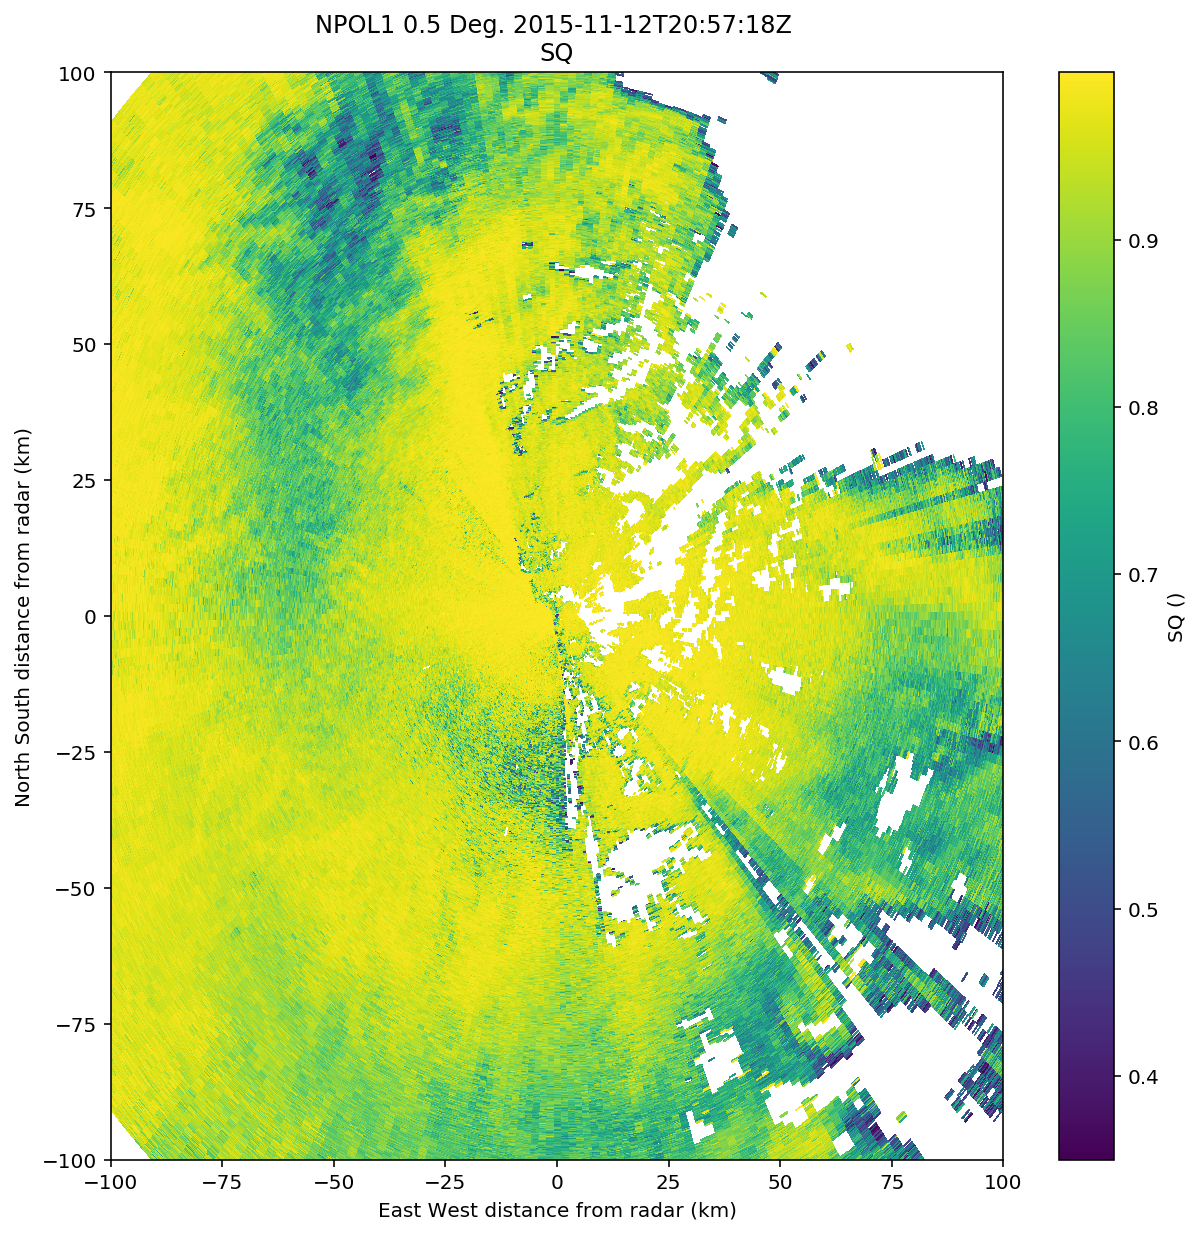

In [10]:
filetest='/data/gpm/a/snesbitt/gpm/olympex/cf/20151112/cfrad.20151112_205701.000_to_20151112_205817.000_NPOL1_v1_PPI.nc'
radar=pyart.io.read_cfradial(filetest)
radar=radar.extract_sweeps(np.arange(0,radar.nsweeps-1))
do_auto_qc(radar)

swp=0

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
display.plot_ppi('CORDBZ', swp)
display.set_limits((-100, 100), (-100, 100), ax=ax)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
display.plot_ppi('SDP', swp)
display.set_limits((-100, 100), (-100, 100), ax=ax)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
display.plot_ppi('RH', swp)
display.set_limits((-100, 100), (-100, 100), ax=ax)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
display.plot_ppi('SQ', swp)
display.set_limits((-100, 100), (-100, 100), ax=ax)


In [14]:
und_trange=[datetime.datetime(2015,11,12,21,55),datetime.datetime(2015,11,12,21,55)]
und_set=[und_trange[0].isoformat(),und_trange[1].isoformat()]
inswp=np.where(kdWKR.flight['time']['data'] > und_trange[0] & kdWKR.flight['time']['data'] < und_trange[1])
lon_und, lat_und = [np.min(kdWKR.flight['lon']), np.max(kdWKR.flight['lon'])],\
    [np.min(kdWKR.flight['lat']), np.max(kdWKR.flight['lat'])]
fig, (ax1) = plt.subplots(1, 1, figsize=(8.0, 8.))
displayWKR = pyart.graph.RadarMapDisplay(radar)
#ax = fig.add_subplot(nrows, 2, index+1)
displayWKR.plot_ppi_map('CORDBZ', 9, vmin=-10., vmax=35.,
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='i',
            min_lon=lon_und[0], max_lon=lon_und[1], min_lat=lat_und[0], max_lat=lat_und[1],
            colorbar_flag=False, ax=ax1)
displayWKR.plot_colorbar(ax=ax1)
f2 = FlightLevel(fl, basemap=displayWKR.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=und_set[0], end_time=und_set[1],)
f2.time_stamps(start_time=und_set[0], end_time=und_set[1],
                           labelspacing=60)

TypeError: unsupported operand type(s) for &: 'datetime.datetime' and 'datetime.datetime'

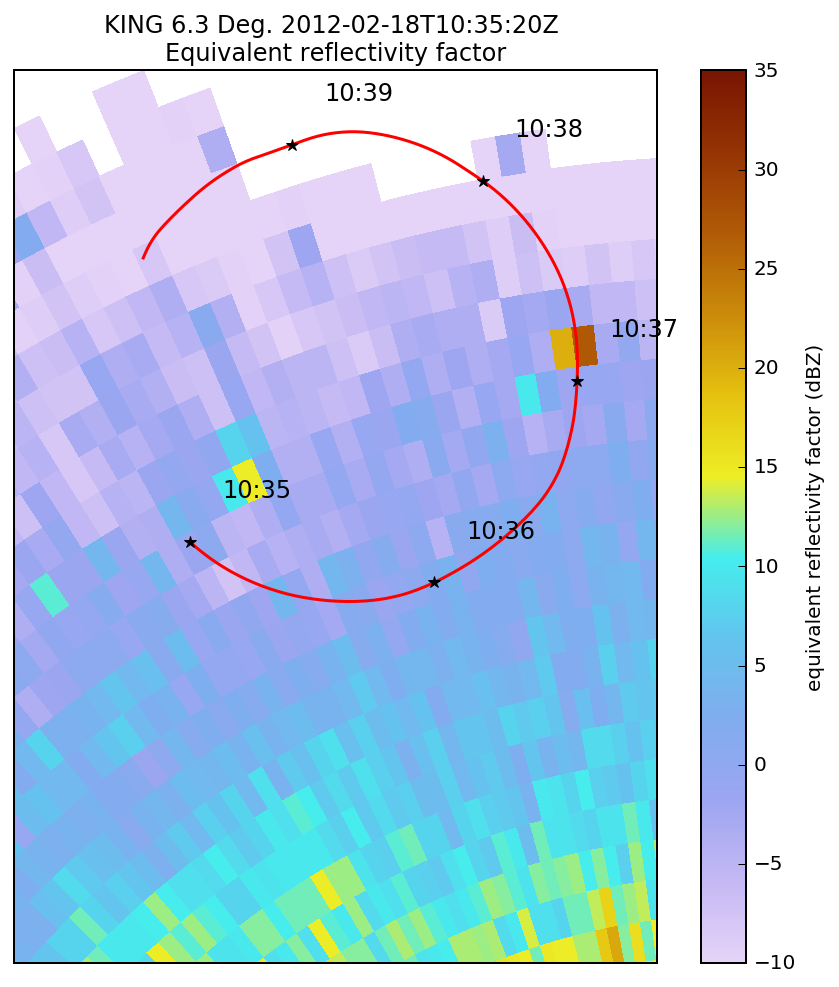

In [27]:
lon_und, lat_und = [-79.8, -79.6], [44.1, 44.3]
und_set=[datetime.datetime(2012,2,18,10,35).isoformat(),datetime.datetime(2012,2,18,10,40).isoformat()]
fig, (ax1) = plt.subplots(1, 1, figsize=(8.0, 8.))
displayWKR = pyart.graph.RadarMapDisplay(radar)
#ax = fig.add_subplot(nrows, 2, index+1)
displayWKR.plot_ppi_map('total_power', 9, vmin=-10., vmax=35.,
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='i',
            min_lon=lon_und[0], max_lon=lon_und[1], min_lat=lat_und[0], max_lat=lat_und[1],
            colorbar_flag=False, ax=ax1)
displayWKR.plot_colorbar(ax=ax1)
f2 = FlightLevel(fl, basemap=displayWKR.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=und_set[0], end_time=und_set[1],)
f2.time_stamps(start_time=und_set[0], end_time=und_set[1],
                           labelspacing=60)

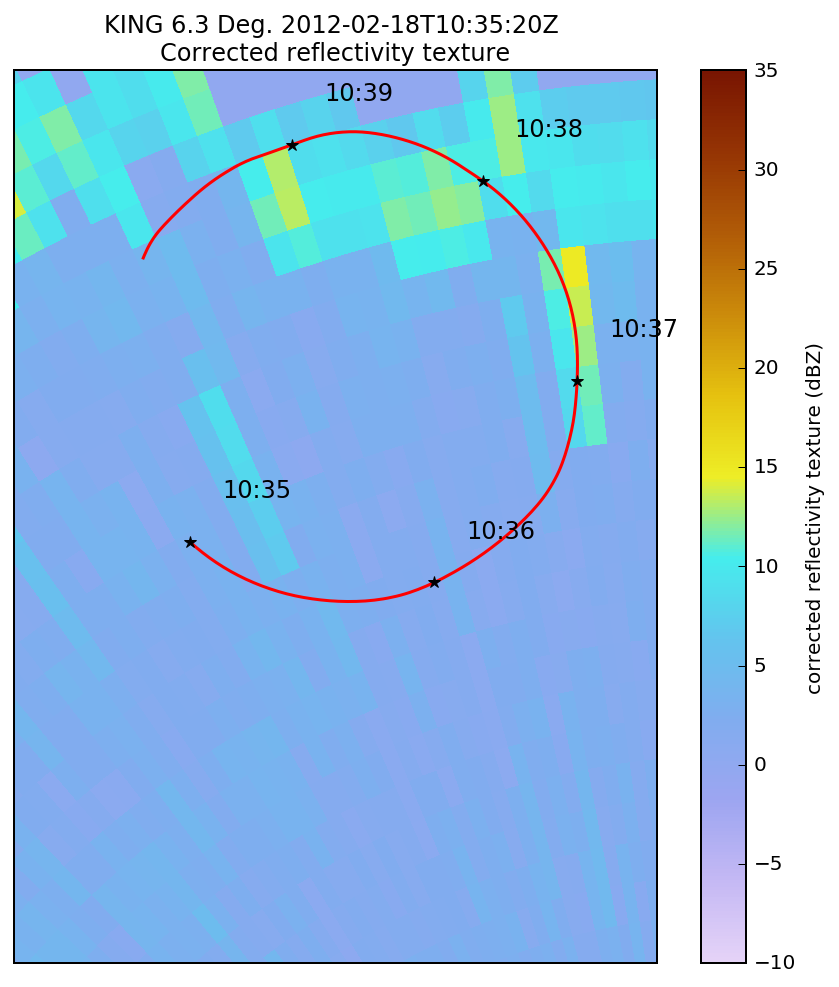

In [28]:
lon_und, lat_und = [-79.8, -79.6], [44.1, 44.3]
und_set=[datetime.datetime(2012,2,18,10,35).isoformat(),datetime.datetime(2012,2,18,10,40).isoformat()]
fig, (ax1) = plt.subplots(1, 1, figsize=(8.0, 8.))
displayWKR = pyart.graph.RadarMapDisplay(radar)
#ax = fig.add_subplot(nrows, 2, index+1)
displayWKR.plot_ppi_map('Ztext', 9, vmin=-10., vmax=35.,
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='i',
            min_lon=lon_und[0], max_lon=lon_und[1], min_lat=lat_und[0], max_lat=lat_und[1],
            colorbar_flag=False, ax=ax1)
displayWKR.plot_colorbar(ax=ax1)
f2 = FlightLevel(fl, basemap=displayWKR.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=und_set[0], end_time=und_set[1],)
f2.time_stamps(start_time=und_set[0], end_time=und_set[1],
                           labelspacing=60)

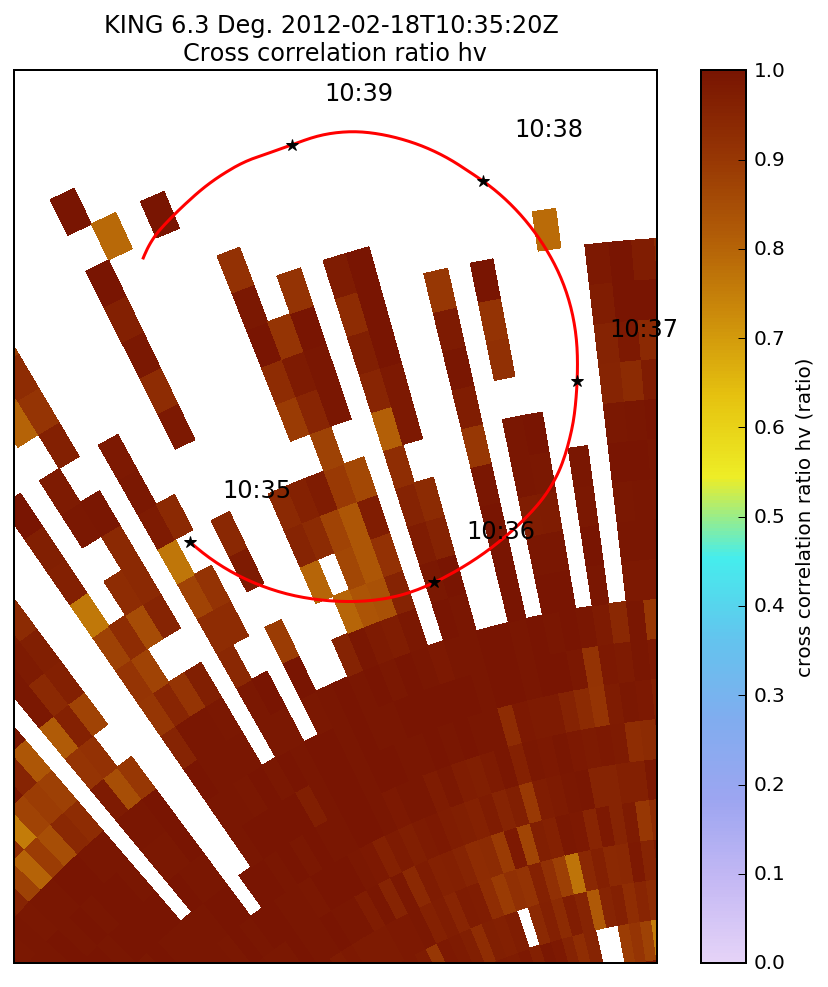

In [29]:
lon_und, lat_und = [-79.8, -79.6], [44.1, 44.3]
und_set=[datetime.datetime(2012,2,18,10,35).isoformat(),datetime.datetime(2012,2,18,10,40).isoformat()]
fig, (ax1) = plt.subplots(1, 1, figsize=(8.0, 8.))
displayWKR = pyart.graph.RadarMapDisplay(radar)
#ax = fig.add_subplot(nrows, 2, index+1)
displayWKR.plot_ppi_map('cross_correlation_ratio', 9, vmin=0., vmax=1.,
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='i',
            min_lon=lon_und[0], max_lon=lon_und[1], min_lat=lat_und[0], max_lat=lat_und[1],
            colorbar_flag=False, ax=ax1)
displayWKR.plot_colorbar(ax=ax1)
f2 = FlightLevel(fl, basemap=displayWKR.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=und_set[0], end_time=und_set[1],)
f2.time_stamps(start_time=und_set[0], end_time=und_set[1],
                           labelspacing=60)

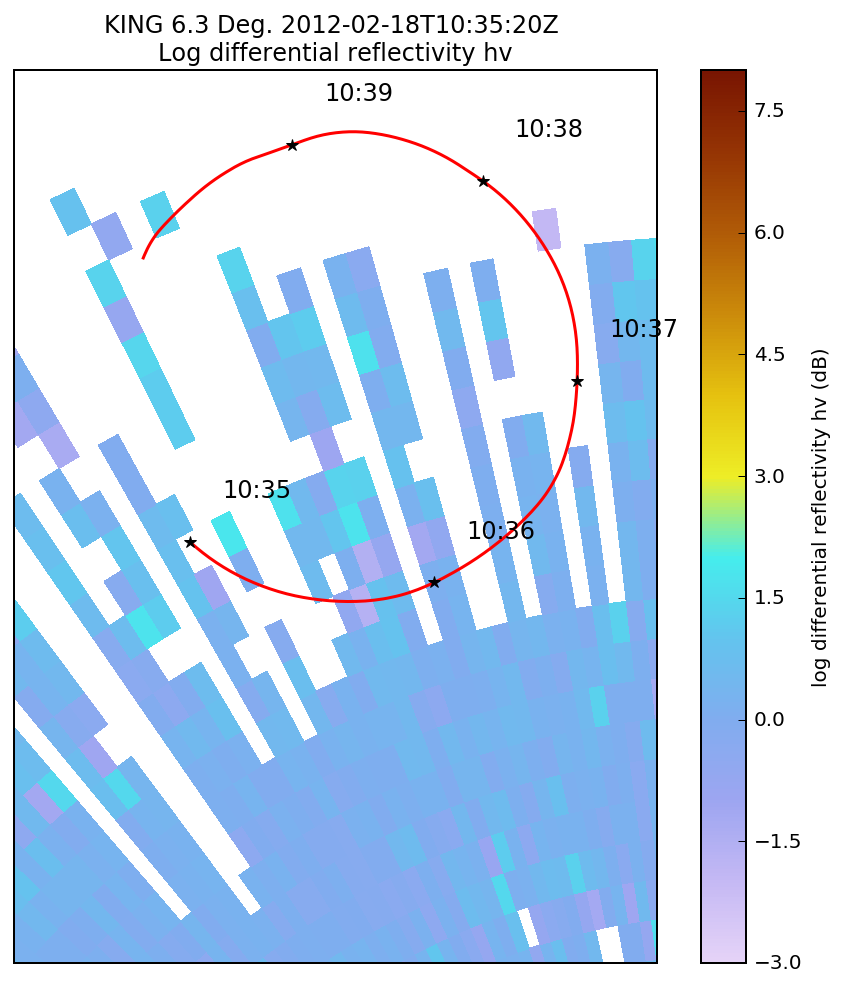

In [30]:
lon_und, lat_und = [-79.8, -79.6], [44.1, 44.3]
und_set=[datetime.datetime(2012,2,18,10,35).isoformat(),datetime.datetime(2012,2,18,10,40).isoformat()]
fig, (ax1) = plt.subplots(1, 1, figsize=(8.0, 8.))
displayWKR = pyart.graph.RadarMapDisplay(radar)
#ax = fig.add_subplot(nrows, 2, index+1)
displayWKR.plot_ppi_map('differential_reflectivity', 9, vmin=-3., vmax=8.,
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='i',
            min_lon=lon_und[0], max_lon=lon_und[1], min_lat=lat_und[0], max_lat=lat_und[1],
            colorbar_flag=False, ax=ax1)
displayWKR.plot_colorbar(ax=ax1)
f2 = FlightLevel(fl, basemap=displayWKR.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=und_set[0], end_time=und_set[1],)
f2.time_stamps(start_time=und_set[0], end_time=und_set[1],
                           labelspacing=60)

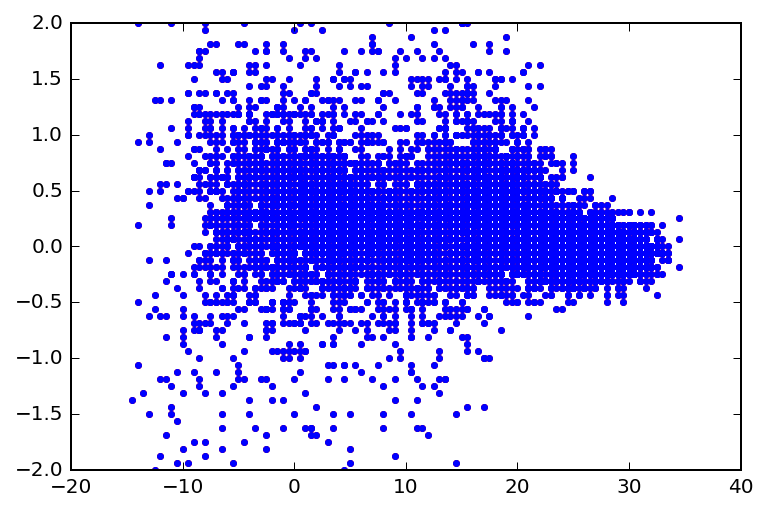

In [31]:
plt.figure()
iswp=radar.extract_sweeps([9])
plt.plot(iswp.fields['reflectivity']['data'][:],iswp.fields['differential_reflectivity']['data'][:],'.r')
plt.plot(iswp.fields['CORDBZ']['data'][:],iswp.fields['differential_reflectivity']['data'][:],'.b')
plt.show()

In [33]:
und_set = [datetime.datetime(2012,2,18,10,35).isoformat(), datetime.datetime(2012,2,18,10,40).isoformat()]
rmatch = awot.util.RadarMatch(fl, radar,
                                   mask_above=1E5,
                                   start_time=und_set[0], end_time=und_set[1],
                                   field_match_dict=['CORDBZ','SDP','KDP','differential_reflectivity',
                                                     'normalized_coherent_power','velocity','cross_correlation_ratio'])
kdWKR = rmatch.kdtree(leafsize=16, query_k=8, Barnes=True, K_d=5e2, Zfield='CORDBZ')

--- 0.879106998444 seconds---


In [23]:
folders=glob.glob("/data/snesbitt/h/snesbitt/gpm/gcpex/cloud_microphysics_Citation/UND_cloud_microphysics/data/QC_Processed/*")
for flights in folders:
    print(flights.split('/')[-1])
    str1=flights.split('/')[-1]
    str2=str1[0:4]+'_'+str1[4:6]+'_'+str1[6:8]+'_'+str1[9:11]+'_'+str1[11:13]+'_'+str1[13:15]
    str3=str1[0:8]
    print str3

20120119_144804
20120119
20120127_015533
20120127
20120128_154901
20120128
20120130_224015
20120130
20120212_030055
20120212
20120212_234037
20120212
20120214_163121
20120214
20120216_142427
20120216
20120218_094352
20120218
20120218_153846
20120218
20120224_113408
20120224
20120224_164010
20120224


In [ ]:
good=np.where((kdWKR.flight['time']['data'] > datetime.datetime(2012,2,18,10,36)) & (kdWKR.flight['time']['data'] < datetime.datetime(2012,2,18,10,37)))

In [50]:
data=pd.DataFrame({'quality_controlled_reflectivity':kdWKR.data['CORDBZ']['data'],
            'specific_differential_phase':kdWKR.data['KDP']['data'],
            'standard_deviation_differential_phase':kdWKR.data['SDP']['data'],
             'standard_deviation_reflectivity':kdWKR.data['Ztext']['data'],
             'cross_correlation_ratio':kdWKR.data['cross_correlation_ratio']['data'],
             'differential_reflectivity':kdWKR.data['differential_reflectivity']['data'],
             'normalized_coherent_power':kdWKR.data['normalized_coherent_power']['data'],
             'reflectivity':kdWKR.data['reflectivity']['data'],
             'total_power':kdWKR.data['total_power']['data']},index=kdWKR.flight['time']['data'])

data.to_csv(str1+'_gcpex_match.csv')

In [46]:
kdWKR.data

{'CORDBZ': {'_FillValue': -9999.0,
  'coordinates': 'elevation azimuth range',
  'data': masked_array(data = [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -5.334188948350476
   -5.366982319969447 -5.389881667127515 -4.270518666280585
   -3.076970420375043 -1.8075310885509086 -1.0625942961616672
   -0.7397173177466427 -0.6102098957591332 -0.5464884621631103
   -0.5279930698180919 -0.5170537759383159 -0.5143414576327132
   -0.5098354414022679 -0.5069930295416879 -0.5025781399237099
   -0.5023388812643258 -0.4999998545660284 -0.4999998545660284
   -0.4999998545660284 -0.4999998545660284 -0.49999985456602786
   -0.49999985456602897 -0.4999998545660284 -0.4999998545660284
   -3.0000002453378922 -3.0000002453378922 -3.0000002453378922
   -3.0000002453378922 -3.0000002453378922 -3.0000002453378922
   -3.0000002453378922 -3.0000002453378922 -3.0000002453378922
   -3.0000002453378922 -3.0000002453378922 -3.0000002453378922
   -3.0000002453378922 -3.0000002453378922 -3.0000002453378922


In [ ]:
radar.time

In [ ]:
radar

In [ ]:
timedata=radar.time['data']
timeunits=radar.time['units']

In [ ]:
timeunits

In [ ]:
num2date(timedata,units = timeunits)

In [ ]:
timedata

In [ ]:
volstart

In [ ]:
radar.range['data']

In [ ]:
kdWKR.data

In [4]:
[x for y, x in sorted(zip(volstart, rflist))]